# DQN

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0') # 200 total reward as goal
env = gym.make('CartPole-v1') # 500 total reward as goal

/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
# env.reset()
# batch = []
# for _ in range(1000):
#     # env.render()
#     action = env.action_space.sample()
#     state, reward, done, info = env.step(action) # take a random action
#     batch.append([action, state, reward, done, info])
#     #print('state, action, reward, done, info:', state, action, reward, done, info)
#     if done:
#         env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
# batch[0], batch[0][1].shape

In [6]:
# actions = np.array([each[0] for each in batch])
# states = np.array([each[1] for each in batch])
# rewards = np.array([each[2] for each in batch])
# dones = np.array([each[3] for each in batch])
# infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    isTraining = tf.placeholder(tf.bool, [], name='isTraining')
    return actions, states, targetQs, isTraining

In [23]:
def actor(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('actor', reuse=reuse):
        # First fully connected layer
        #h1 = tf.layers.dense(inputs=states, units=hidden_size) # no weight init
        h1 = tf.contrib.layers.fully_connected(inputs=states, num_outputs=hidden_size, activation_fn=None)     
        bn1 = tf.contrib.layers.batch_norm(inputs=h1, is_training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        #h2 = tf.layers.dense(inputs=nl1, units=hidden_size) # no weight init
        h2 = tf.contrib.layers.fully_connected(inputs=nl1, num_outputs=hidden_size, activation_fn=None)
        bn2 = tf.contrib.layers.batch_norm(inputs=h2, is_training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        #logits = tf.layers.dense(inputs=nl2, units=action_size)
        logits = tf.contrib.layers.fully_connected(inputs=nl2, num_outputs=action_size, activation_fn=None)
        return logits

In [24]:
# def actor_target(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
#     with tf.variable_scope('actor_target', reuse=reuse):
#         # First fully connected layer
#         #h1 = tf.layers.dense(inputs=states, units=hidden_size) # no weight init
#         h1 = tf.contrib.layers.fully_connected(inputs=states, num_outputs=hidden_size, activation_fn=None)     
#         bn1 = tf.layers.batch_normalization(h1, training=training)        
#         nl1 = tf.maximum(alpha * bn1, bn1)
        
#         # Second fully connected layer
#         #h2 = tf.layers.dense(inputs=nl1, units=hidden_size) # no weight init
#         h2 = tf.contrib.layers.fully_connected(inputs=nl1, num_outputs=hidden_size, activation_fn=None)
#         bn2 = tf.layers.batch_normalization(h2, training=training)        
#         nl2 = tf.maximum(alpha * bn2, bn2)
        
#         # Output layer
#         #logits = tf.layers.dense(inputs=nl2, units=action_size)
#         logits = tf.contrib.layers.fully_connected(inputs=nl2, num_outputs=action_size, activation_fn=None)
#         return logits

In [25]:
def model_loss(actions, states, targetQs, action_size, hidden_size, isTraining):
    #     actions_target = actor_target(states=states, hidden_size=hidden_size, action_size=action_size, 
    #                                   training=isTraining)
    actions_logits = actor(states=states, hidden_size=hidden_size, action_size=action_size, training=isTraining)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    return actions_logits, loss

In [26]:
def model_opt(loss, learning_rate, gamma):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('actor')]
    #g_vars_tgt = [var for var in t_vars if var.name.startswith('actor_target')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)
        
    #     opt_tgt = [g_vars_tgt[idx].assign((g_vars_tgt[idx]*gamma) + (g_vars[idx]*(1-gamma))) 
    #                for idx in range(len(g_vars_tgt))]
    return opt

In [27]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs, self.isTraining = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, isTraining=self.isTraining)

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate, gamma=gamma)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [28]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [29]:
env.observation_space, env.action_space, \
env.observation_space.low, env.observation_space.high, \
env.action_space.n

(Box(4,),
 Discrete(2),
 array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
       dtype=float32),
 array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
       dtype=float32),
 2)

In [30]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
gamma = 0.99                   # future reward discount

In [31]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate, 
              gamma=gamma)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [32]:
state = env.reset()

for _ in range(memory_size):
    action = env.action_space.sample()
    
    next_state, reward, done, _ = env.step(action)
    
    memory.buffer.append([state, action, next_state, reward, float(done)])
    
    state = next_state
    
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    n_episodes = 100000000
    
    # Training episodes/epochs
    for ep in range(n_episodes):
        total_reward = 0
        loss_batch = []
        state = env.reset()

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1]), 
                                                                          model.isTraining: False})
                action = np.argmax(action_logits)
                
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state

            # minibatch
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            
            # targetQs
            next_actions_logits = sess.run(model.actions_logits, feed_dict = {model.states: next_states, 
                                                                              model.isTraining: False})
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (gamma * nextQs)

            # train
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                     model.actions: actions,
                                                                     model.targetQs: targetQs, 
                                                                     model.isTraining: True})
            loss_batch.append(loss)
            
            #             # Train target network
            #             sess.run(model.opt_tgt)
            #             #             , feed_dict = {model.states: states, 
            #             #                                                  model.actions: actions,
            #             #                                                  model.targetQs: targetQs, 
            #             #                                                  model.isTraining: True})
            
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'loss:{:.4f}'.format(np.mean(loss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:34.0000 R:34.0 loss:0.4966 exploreP:0.9966
Episode:1 meanR:24.0000 R:14.0 loss:0.4459 exploreP:0.9953
Episode:2 meanR:25.6667 R:29.0 loss:0.4009 exploreP:0.9924
Episode:3 meanR:22.2500 R:12.0 loss:0.3174 exploreP:0.9912
Episode:4 meanR:24.6000 R:34.0 loss:0.2638 exploreP:0.9879
Episode:5 meanR:24.6667 R:25.0 loss:0.2279 exploreP:0.9855
Episode:6 meanR:25.0000 R:27.0 loss:0.1810 exploreP:0.9828
Episode:7 meanR:23.7500 R:15.0 loss:0.1616 exploreP:0.9814
Episode:8 meanR:22.6667 R:14.0 loss:0.1501 exploreP:0.9800
Episode:9 meanR:21.3000 R:9.0 loss:0.1282 exploreP:0.9791
Episode:10 meanR:21.5455 R:24.0 loss:0.1226 exploreP:0.9768
Episode:11 meanR:21.0833 R:16.0 loss:0.1224 exploreP:0.9753
Episode:12 meanR:20.4615 R:13.0 loss:0.1090 exploreP:0.9740
Episode:13 meanR:19.7857 R:11.0 loss:0.0964 exploreP:0.9730
Episode:14 meanR:20.7333 R:34.0 loss:0.0959 exploreP:0.9697
Episode:15 meanR:20.6250 R:19.0 loss:0.0751 exploreP:0.9679
Episode:16 meanR:20.5294 R:19.0 loss:0.0864 explore

Episode:138 meanR:20.2500 R:19.0 loss:1.1816 exploreP:0.7506
Episode:139 meanR:20.2800 R:17.0 loss:0.7440 exploreP:0.7494
Episode:140 meanR:20.7500 R:62.0 loss:0.9616 exploreP:0.7448
Episode:141 meanR:20.8100 R:23.0 loss:0.9483 exploreP:0.7431
Episode:142 meanR:20.7200 R:13.0 loss:0.8850 exploreP:0.7422
Episode:143 meanR:20.6000 R:26.0 loss:1.0816 exploreP:0.7403
Episode:144 meanR:20.6500 R:20.0 loss:0.8869 exploreP:0.7388
Episode:145 meanR:20.7100 R:18.0 loss:1.3619 exploreP:0.7375
Episode:146 meanR:20.5500 R:18.0 loss:1.4208 exploreP:0.7362
Episode:147 meanR:20.6400 R:26.0 loss:1.1285 exploreP:0.7343
Episode:148 meanR:20.6400 R:16.0 loss:1.0582 exploreP:0.7331
Episode:149 meanR:20.8500 R:41.0 loss:1.2089 exploreP:0.7302
Episode:150 meanR:20.3600 R:15.0 loss:1.4141 exploreP:0.7291
Episode:151 meanR:20.1000 R:12.0 loss:1.1533 exploreP:0.7282
Episode:152 meanR:20.1200 R:10.0 loss:1.6127 exploreP:0.7275
Episode:153 meanR:20.0700 R:10.0 loss:1.1274 exploreP:0.7268
Episode:154 meanR:19.910

Episode:273 meanR:47.4400 R:59.0 loss:3.6740 exploreP:0.4397
Episode:274 meanR:47.7500 R:51.0 loss:3.1985 exploreP:0.4375
Episode:275 meanR:48.5700 R:100.0 loss:2.9169 exploreP:0.4332
Episode:276 meanR:48.8000 R:43.0 loss:3.2301 exploreP:0.4314
Episode:277 meanR:49.8100 R:118.0 loss:4.5672 exploreP:0.4265
Episode:278 meanR:50.3300 R:70.0 loss:3.3823 exploreP:0.4236
Episode:279 meanR:50.7800 R:58.0 loss:3.9779 exploreP:0.4212
Episode:280 meanR:50.8500 R:27.0 loss:3.2301 exploreP:0.4201
Episode:281 meanR:51.0900 R:33.0 loss:3.6812 exploreP:0.4187
Episode:282 meanR:51.0700 R:33.0 loss:5.1959 exploreP:0.4174
Episode:283 meanR:51.4800 R:56.0 loss:4.8133 exploreP:0.4151
Episode:284 meanR:52.6800 R:137.0 loss:3.5404 exploreP:0.4096
Episode:285 meanR:53.3900 R:88.0 loss:3.0667 exploreP:0.4061
Episode:286 meanR:53.5500 R:29.0 loss:4.3386 exploreP:0.4049
Episode:287 meanR:55.1100 R:213.0 loss:4.3944 exploreP:0.3966
Episode:288 meanR:59.9500 R:500.0 loss:4.8755 exploreP:0.3778
Episode:289 meanR:6

Episode:406 meanR:134.1700 R:10.0 loss:35.2164 exploreP:0.0832
Episode:407 meanR:133.1200 R:8.0 loss:32.1272 exploreP:0.0831
Episode:408 meanR:130.0100 R:10.0 loss:81.8397 exploreP:0.0831
Episode:409 meanR:125.3200 R:10.0 loss:32.7755 exploreP:0.0830
Episode:410 meanR:122.6600 R:10.0 loss:24.0672 exploreP:0.0829
Episode:411 meanR:121.9200 R:10.0 loss:23.5629 exploreP:0.0828
Episode:412 meanR:120.9700 R:13.0 loss:29.2031 exploreP:0.0827
Episode:413 meanR:119.9000 R:11.0 loss:36.3373 exploreP:0.0827
Episode:414 meanR:118.8600 R:10.0 loss:45.3184 exploreP:0.0826
Episode:415 meanR:118.0100 R:12.0 loss:27.0068 exploreP:0.0825
Episode:416 meanR:116.6000 R:10.0 loss:37.3801 exploreP:0.0824
Episode:417 meanR:115.0300 R:12.0 loss:45.8772 exploreP:0.0823
Episode:418 meanR:112.8600 R:8.0 loss:52.5956 exploreP:0.0823
Episode:419 meanR:112.1700 R:11.0 loss:36.4014 exploreP:0.0822
Episode:420 meanR:111.2600 R:10.0 loss:32.3189 exploreP:0.0821
Episode:421 meanR:110.4700 R:9.0 loss:24.7422 exploreP:0.

Episode:538 meanR:72.1300 R:58.0 loss:21.4454 exploreP:0.0444
Episode:539 meanR:72.5300 R:48.0 loss:18.5480 exploreP:0.0443
Episode:540 meanR:72.8600 R:43.0 loss:22.3624 exploreP:0.0441
Episode:541 meanR:73.2400 R:47.0 loss:17.7771 exploreP:0.0440
Episode:542 meanR:73.5200 R:38.0 loss:22.9164 exploreP:0.0438
Episode:543 meanR:73.8600 R:42.0 loss:12.0063 exploreP:0.0437
Episode:544 meanR:74.2300 R:45.0 loss:11.7385 exploreP:0.0436
Episode:545 meanR:74.5400 R:43.0 loss:12.7768 exploreP:0.0434
Episode:546 meanR:74.8800 R:45.0 loss:15.5676 exploreP:0.0433
Episode:547 meanR:75.3400 R:55.0 loss:12.2096 exploreP:0.0431
Episode:548 meanR:75.7500 R:51.0 loss:10.5381 exploreP:0.0429
Episode:549 meanR:76.0800 R:43.0 loss:15.9573 exploreP:0.0428
Episode:550 meanR:76.5600 R:58.0 loss:27.4753 exploreP:0.0426
Episode:551 meanR:77.3500 R:87.0 loss:60.2314 exploreP:0.0423
Episode:552 meanR:80.3000 R:304.0 loss:113.1698 exploreP:0.0413
Episode:553 meanR:81.1200 R:92.0 loss:103.6571 exploreP:0.0410
Episo

Episode:670 meanR:94.8500 R:10.0 loss:11.4812 exploreP:0.0201
Episode:671 meanR:93.3300 R:10.0 loss:18.8592 exploreP:0.0200
Episode:672 meanR:89.9800 R:165.0 loss:11.0921 exploreP:0.0199
Episode:673 meanR:88.1500 R:16.0 loss:5.8187 exploreP:0.0199
Episode:674 meanR:87.9300 R:186.0 loss:8.1860 exploreP:0.0197
Episode:675 meanR:84.6800 R:175.0 loss:15.3019 exploreP:0.0195
Episode:676 meanR:86.6500 R:362.0 loss:43.4565 exploreP:0.0192
Episode:677 meanR:87.2300 R:196.0 loss:68.1778 exploreP:0.0190
Episode:678 meanR:87.3400 R:126.0 loss:38.5106 exploreP:0.0189
Episode:679 meanR:87.4100 R:127.0 loss:29.0109 exploreP:0.0188
Episode:680 meanR:87.1300 R:104.0 loss:30.1085 exploreP:0.0187
Episode:681 meanR:87.1600 R:121.0 loss:21.5204 exploreP:0.0186
Episode:682 meanR:87.4100 R:113.0 loss:26.5677 exploreP:0.0185
Episode:683 meanR:88.4400 R:161.0 loss:24.8945 exploreP:0.0183
Episode:684 meanR:91.0300 R:315.0 loss:43.4344 exploreP:0.0181
Episode:685 meanR:92.0200 R:160.0 loss:262.0345 exploreP:0.0

Episode:804 meanR:87.4900 R:10.0 loss:25.6831 exploreP:0.0130
Episode:805 meanR:87.1600 R:11.0 loss:14.3145 exploreP:0.0130
Episode:806 meanR:86.8300 R:10.0 loss:31.1416 exploreP:0.0130
Episode:807 meanR:86.4600 R:10.0 loss:30.9112 exploreP:0.0130
Episode:808 meanR:85.9900 R:10.0 loss:15.8310 exploreP:0.0130
Episode:809 meanR:85.6900 R:11.0 loss:42.2201 exploreP:0.0130
Episode:810 meanR:85.1800 R:10.0 loss:26.2305 exploreP:0.0130
Episode:811 meanR:84.8000 R:10.0 loss:26.1356 exploreP:0.0130
Episode:812 meanR:84.5300 R:14.0 loss:15.1820 exploreP:0.0129
Episode:813 meanR:84.0100 R:9.0 loss:19.9027 exploreP:0.0129
Episode:814 meanR:83.5900 R:10.0 loss:10.3069 exploreP:0.0129
Episode:815 meanR:83.0700 R:9.0 loss:9.0220 exploreP:0.0129
Episode:816 meanR:78.1600 R:9.0 loss:24.7086 exploreP:0.0129
Episode:817 meanR:74.0400 R:28.0 loss:19.1981 exploreP:0.0129
Episode:818 meanR:71.4600 R:11.0 loss:42.3718 exploreP:0.0129
Episode:819 meanR:70.5600 R:9.0 loss:30.7102 exploreP:0.0129
Episode:820 m

Episode:937 meanR:31.4400 R:52.0 loss:509.6701 exploreP:0.0121
Episode:938 meanR:32.1800 R:85.0 loss:326.0317 exploreP:0.0121
Episode:939 meanR:32.9000 R:81.0 loss:249.2487 exploreP:0.0121
Episode:940 meanR:33.3100 R:51.0 loss:219.7043 exploreP:0.0120
Episode:941 meanR:33.5800 R:37.0 loss:176.2434 exploreP:0.0120
Episode:942 meanR:33.7100 R:24.0 loss:129.4993 exploreP:0.0120
Episode:943 meanR:34.0000 R:39.0 loss:110.4686 exploreP:0.0120
Episode:944 meanR:34.4100 R:53.0 loss:101.3057 exploreP:0.0120
Episode:945 meanR:34.6500 R:34.0 loss:95.7433 exploreP:0.0120
Episode:946 meanR:34.7700 R:32.0 loss:84.9952 exploreP:0.0120
Episode:947 meanR:34.9900 R:33.0 loss:95.1858 exploreP:0.0120
Episode:948 meanR:35.1100 R:32.0 loss:94.1094 exploreP:0.0120
Episode:949 meanR:35.4000 R:39.0 loss:82.1777 exploreP:0.0120
Episode:950 meanR:35.5800 R:28.0 loss:77.8353 exploreP:0.0120
Episode:951 meanR:35.9300 R:45.0 loss:68.3192 exploreP:0.0120
Episode:952 meanR:36.0800 R:25.0 loss:57.4923 exploreP:0.0120


Episode:1068 meanR:64.7900 R:96.0 loss:40.2313 exploreP:0.0110
Episode:1069 meanR:65.5600 R:94.0 loss:106.2899 exploreP:0.0110
Episode:1070 meanR:66.5000 R:105.0 loss:218.6973 exploreP:0.0110
Episode:1071 meanR:67.6500 R:143.0 loss:260.8394 exploreP:0.0110
Episode:1072 meanR:69.0600 R:164.0 loss:117.1928 exploreP:0.0109
Episode:1073 meanR:70.7000 R:173.0 loss:46.5289 exploreP:0.0109
Episode:1074 meanR:71.6000 R:99.0 loss:125.4222 exploreP:0.0109
Episode:1075 meanR:73.5500 R:205.0 loss:80.3985 exploreP:0.0109
Episode:1076 meanR:74.3400 R:89.0 loss:34.4615 exploreP:0.0109
Episode:1077 meanR:75.1700 R:92.0 loss:33.7440 exploreP:0.0109
Episode:1078 meanR:75.7400 R:65.0 loss:21.8283 exploreP:0.0109
Episode:1079 meanR:76.3700 R:73.0 loss:13.6066 exploreP:0.0109
Episode:1080 meanR:76.8800 R:59.0 loss:23.2041 exploreP:0.0109
Episode:1081 meanR:77.9100 R:121.0 loss:153.1103 exploreP:0.0109
Episode:1082 meanR:79.9300 R:210.0 loss:254.7040 exploreP:0.0108
Episode:1083 meanR:82.8500 R:301.0 loss:9

Episode:1201 meanR:39.1800 R:10.0 loss:79.5421 exploreP:0.0105
Episode:1202 meanR:38.4400 R:10.0 loss:74.8350 exploreP:0.0105
Episode:1203 meanR:37.6700 R:9.0 loss:51.4753 exploreP:0.0105
Episode:1204 meanR:36.8900 R:9.0 loss:76.4074 exploreP:0.0105
Episode:1205 meanR:36.0700 R:8.0 loss:53.1884 exploreP:0.0105
Episode:1206 meanR:35.3300 R:10.0 loss:59.5383 exploreP:0.0105
Episode:1207 meanR:34.6400 R:10.0 loss:90.3085 exploreP:0.0105
Episode:1208 meanR:33.9400 R:10.0 loss:71.1291 exploreP:0.0105
Episode:1209 meanR:33.2600 R:11.0 loss:76.5057 exploreP:0.0105
Episode:1210 meanR:32.5600 R:10.0 loss:75.1483 exploreP:0.0105
Episode:1211 meanR:31.8100 R:8.0 loss:69.2367 exploreP:0.0105
Episode:1212 meanR:31.1200 R:8.0 loss:80.9535 exploreP:0.0105
Episode:1213 meanR:30.9500 R:10.0 loss:55.8796 exploreP:0.0105
Episode:1214 meanR:30.7600 R:11.0 loss:41.9685 exploreP:0.0104
Episode:1215 meanR:30.6100 R:10.0 loss:54.0726 exploreP:0.0104
Episode:1216 meanR:30.4700 R:9.0 loss:69.9199 exploreP:0.010

Episode:1331 meanR:108.2700 R:55.0 loss:370.9518 exploreP:0.0101
Episode:1332 meanR:107.9900 R:68.0 loss:281.8810 exploreP:0.0101
Episode:1333 meanR:108.1600 R:72.0 loss:212.0000 exploreP:0.0101
Episode:1334 meanR:108.4700 R:68.0 loss:194.3790 exploreP:0.0101
Episode:1335 meanR:107.9200 R:67.0 loss:184.3175 exploreP:0.0101
Episode:1336 meanR:108.2200 R:96.0 loss:111.1496 exploreP:0.0101
Episode:1337 meanR:107.5200 R:104.0 loss:49.6525 exploreP:0.0101
Episode:1338 meanR:107.9300 R:83.0 loss:77.3501 exploreP:0.0101
Episode:1339 meanR:108.3000 R:72.0 loss:229.6826 exploreP:0.0101
Episode:1340 meanR:108.5500 R:68.0 loss:200.4925 exploreP:0.0101
Episode:1341 meanR:108.8400 R:73.0 loss:198.2404 exploreP:0.0101
Episode:1342 meanR:109.2700 R:75.0 loss:228.8965 exploreP:0.0101
Episode:1343 meanR:110.3500 R:175.0 loss:147.9210 exploreP:0.0101
Episode:1344 meanR:111.0000 R:182.0 loss:65.2087 exploreP:0.0101
Episode:1345 meanR:110.5900 R:60.0 loss:36.4407 exploreP:0.0101
Episode:1346 meanR:110.030

Episode:1466 meanR:11.4200 R:9.0 loss:23.7102 exploreP:0.0101
Episode:1467 meanR:11.3900 R:8.0 loss:22.8872 exploreP:0.0101
Episode:1468 meanR:11.3900 R:8.0 loss:33.3938 exploreP:0.0101
Episode:1469 meanR:11.4100 R:10.0 loss:41.8062 exploreP:0.0101
Episode:1470 meanR:11.4100 R:10.0 loss:61.0310 exploreP:0.0101
Episode:1471 meanR:11.4300 R:10.0 loss:45.2973 exploreP:0.0101
Episode:1472 meanR:11.4200 R:10.0 loss:53.9622 exploreP:0.0101
Episode:1473 meanR:11.4000 R:8.0 loss:33.4678 exploreP:0.0101
Episode:1474 meanR:11.4000 R:8.0 loss:62.2200 exploreP:0.0101
Episode:1475 meanR:11.4000 R:10.0 loss:80.0249 exploreP:0.0101
Episode:1476 meanR:11.4100 R:10.0 loss:83.0552 exploreP:0.0101
Episode:1477 meanR:11.4100 R:10.0 loss:143.0279 exploreP:0.0101
Episode:1478 meanR:11.3900 R:8.0 loss:93.3683 exploreP:0.0101
Episode:1479 meanR:11.3800 R:9.0 loss:106.5426 exploreP:0.0101
Episode:1480 meanR:11.3800 R:10.0 loss:112.0940 exploreP:0.0101
Episode:1481 meanR:11.3800 R:10.0 loss:61.1399 exploreP:0.0

Episode:1596 meanR:115.6900 R:36.0 loss:138.5927 exploreP:0.0100
Episode:1597 meanR:115.9500 R:35.0 loss:490.9887 exploreP:0.0100
Episode:1598 meanR:116.3100 R:46.0 loss:865.8872 exploreP:0.0100
Episode:1599 meanR:116.6900 R:47.0 loss:1199.8931 exploreP:0.0100
Episode:1600 meanR:117.3600 R:75.0 loss:1510.1924 exploreP:0.0100
Episode:1601 meanR:118.4700 R:121.0 loss:1404.1793 exploreP:0.0100
Episode:1602 meanR:121.4000 R:326.0 loss:1184.2679 exploreP:0.0100
Episode:1603 meanR:122.8000 R:171.0 loss:791.3746 exploreP:0.0100
Episode:1604 meanR:124.3200 R:206.0 loss:389.7468 exploreP:0.0100
Episode:1605 meanR:128.6200 R:500.0 loss:223.0292 exploreP:0.0100
Episode:1606 meanR:130.5400 R:338.0 loss:41.0229 exploreP:0.0100
Episode:1607 meanR:129.9700 R:169.0 loss:29.9107 exploreP:0.0100
Episode:1608 meanR:131.3000 R:500.0 loss:45.8268 exploreP:0.0100
Episode:1609 meanR:130.0800 R:54.0 loss:358.4697 exploreP:0.0100
Episode:1610 meanR:128.9000 R:181.0 loss:1239.4537 exploreP:0.0100
Episode:1611 m

Episode:1724 meanR:47.0100 R:23.0 loss:310.6980 exploreP:0.0100
Episode:1725 meanR:47.1000 R:48.0 loss:429.4419 exploreP:0.0100
Episode:1726 meanR:46.8500 R:23.0 loss:186.5614 exploreP:0.0100
Episode:1727 meanR:46.9800 R:42.0 loss:311.8996 exploreP:0.0100
Episode:1728 meanR:46.9800 R:28.0 loss:330.7022 exploreP:0.0100
Episode:1729 meanR:47.1200 R:72.0 loss:343.9417 exploreP:0.0100
Episode:1730 meanR:49.8300 R:311.0 loss:156.6980 exploreP:0.0100
Episode:1731 meanR:50.2200 R:73.0 loss:54.5777 exploreP:0.0100
Episode:1732 meanR:51.3200 R:133.0 loss:62.7696 exploreP:0.0100
Episode:1733 meanR:52.0600 R:92.0 loss:37.4144 exploreP:0.0100
Episode:1734 meanR:52.5900 R:71.0 loss:41.9395 exploreP:0.0100
Episode:1735 meanR:53.1300 R:72.0 loss:42.5413 exploreP:0.0100
Episode:1736 meanR:53.0800 R:56.0 loss:49.9557 exploreP:0.0100
Episode:1737 meanR:53.1600 R:53.0 loss:49.8443 exploreP:0.0100
Episode:1738 meanR:53.5100 R:63.0 loss:37.9404 exploreP:0.0100
Episode:1739 meanR:53.5600 R:40.0 loss:49.4418

Episode:1852 meanR:121.8000 R:118.0 loss:95.4972 exploreP:0.0100
Episode:1853 meanR:122.7800 R:121.0 loss:204.8612 exploreP:0.0100
Episode:1854 meanR:123.6400 R:113.0 loss:532.2415 exploreP:0.0100
Episode:1855 meanR:124.5300 R:113.0 loss:599.9709 exploreP:0.0100
Episode:1856 meanR:125.5800 R:123.0 loss:594.7915 exploreP:0.0100
Episode:1857 meanR:126.3900 R:107.0 loss:423.2087 exploreP:0.0100
Episode:1858 meanR:127.4700 R:131.0 loss:226.2974 exploreP:0.0100
Episode:1859 meanR:128.6300 R:137.0 loss:53.8948 exploreP:0.0100
Episode:1860 meanR:129.7500 R:132.0 loss:22.5562 exploreP:0.0100
Episode:1861 meanR:130.9900 R:138.0 loss:30.7639 exploreP:0.0100
Episode:1862 meanR:132.2500 R:143.0 loss:88.2453 exploreP:0.0100
Episode:1863 meanR:133.5000 R:140.0 loss:464.2069 exploreP:0.0100
Episode:1864 meanR:134.6800 R:136.0 loss:372.8766 exploreP:0.0100
Episode:1865 meanR:135.3600 R:84.0 loss:264.0500 exploreP:0.0100
Episode:1866 meanR:135.4400 R:27.0 loss:321.2584 exploreP:0.0100
Episode:1867 mean

Episode:1979 meanR:78.9500 R:22.0 loss:433.2261 exploreP:0.0100
Episode:1980 meanR:78.9900 R:15.0 loss:448.8581 exploreP:0.0100
Episode:1981 meanR:79.0700 R:18.0 loss:316.2942 exploreP:0.0100
Episode:1982 meanR:79.1200 R:15.0 loss:480.3961 exploreP:0.0100
Episode:1983 meanR:79.1600 R:14.0 loss:544.7835 exploreP:0.0100
Episode:1984 meanR:79.2300 R:17.0 loss:493.0144 exploreP:0.0100
Episode:1985 meanR:79.2400 R:17.0 loss:674.2932 exploreP:0.0100
Episode:1986 meanR:79.3100 R:21.0 loss:625.9869 exploreP:0.0100
Episode:1987 meanR:79.3000 R:13.0 loss:710.8134 exploreP:0.0100
Episode:1988 meanR:79.3100 R:10.0 loss:748.6030 exploreP:0.0100
Episode:1989 meanR:79.3700 R:17.0 loss:567.7411 exploreP:0.0100
Episode:1990 meanR:79.3600 R:15.0 loss:574.8033 exploreP:0.0100
Episode:1991 meanR:79.4100 R:20.0 loss:653.6340 exploreP:0.0100
Episode:1992 meanR:79.3700 R:15.0 loss:481.2923 exploreP:0.0100
Episode:1993 meanR:79.2900 R:14.0 loss:623.0248 exploreP:0.0100
Episode:1994 meanR:78.6300 R:11.0 loss:4

Episode:2107 meanR:39.0000 R:115.0 loss:1097.5402 exploreP:0.0100
Episode:2108 meanR:39.1800 R:33.0 loss:956.2551 exploreP:0.0100
Episode:2109 meanR:41.1800 R:210.0 loss:347.0249 exploreP:0.0100
Episode:2110 meanR:42.1000 R:109.0 loss:340.0786 exploreP:0.0100
Episode:2111 meanR:43.1400 R:118.0 loss:356.9392 exploreP:0.0100
Episode:2112 meanR:44.0100 R:104.0 loss:246.3725 exploreP:0.0100
Episode:2113 meanR:44.6900 R:85.0 loss:216.1745 exploreP:0.0100
Episode:2114 meanR:45.3500 R:76.0 loss:133.1143 exploreP:0.0100
Episode:2115 meanR:45.2900 R:14.0 loss:67.6901 exploreP:0.0100
Episode:2116 meanR:45.5300 R:40.0 loss:72.0312 exploreP:0.0100
Episode:2117 meanR:46.4700 R:109.0 loss:67.6623 exploreP:0.0100
Episode:2118 meanR:47.5300 R:118.0 loss:42.1051 exploreP:0.0100
Episode:2119 meanR:49.1500 R:176.0 loss:44.1103 exploreP:0.0100
Episode:2120 meanR:51.0100 R:199.0 loss:42.2984 exploreP:0.0100
Episode:2121 meanR:53.3100 R:240.0 loss:133.0495 exploreP:0.0100
Episode:2122 meanR:54.9600 R:178.0 

Episode:2237 meanR:51.1800 R:16.0 loss:1944.5786 exploreP:0.0100
Episode:2238 meanR:50.6500 R:19.0 loss:1540.5297 exploreP:0.0100
Episode:2239 meanR:49.7100 R:16.0 loss:2110.8633 exploreP:0.0100
Episode:2240 meanR:49.0900 R:20.0 loss:2107.9536 exploreP:0.0100
Episode:2241 meanR:48.3300 R:17.0 loss:1792.5824 exploreP:0.0100
Episode:2242 meanR:47.3800 R:19.0 loss:2049.0674 exploreP:0.0100
Episode:2243 meanR:45.7200 R:15.0 loss:1510.0043 exploreP:0.0100
Episode:2244 meanR:44.0600 R:16.0 loss:1553.0485 exploreP:0.0100
Episode:2245 meanR:42.3300 R:17.0 loss:1667.3656 exploreP:0.0100
Episode:2246 meanR:41.5100 R:14.0 loss:1831.8744 exploreP:0.0100
Episode:2247 meanR:41.5200 R:14.0 loss:1676.0315 exploreP:0.0100
Episode:2248 meanR:41.2100 R:9.0 loss:1151.4421 exploreP:0.0100
Episode:2249 meanR:41.2100 R:10.0 loss:1552.1427 exploreP:0.0100
Episode:2250 meanR:41.1900 R:10.0 loss:1993.6257 exploreP:0.0100
Episode:2251 meanR:41.2200 R:13.0 loss:992.9269 exploreP:0.0100
Episode:2252 meanR:41.2200 

Episode:2367 meanR:20.0700 R:32.0 loss:40.4994 exploreP:0.0100
Episode:2368 meanR:20.3700 R:39.0 loss:53.8253 exploreP:0.0100
Episode:2369 meanR:20.6600 R:38.0 loss:72.7872 exploreP:0.0100
Episode:2370 meanR:20.9000 R:33.0 loss:110.4820 exploreP:0.0100
Episode:2371 meanR:21.1000 R:29.0 loss:137.7106 exploreP:0.0100
Episode:2372 meanR:21.3200 R:31.0 loss:194.1832 exploreP:0.0100
Episode:2373 meanR:21.5800 R:38.0 loss:197.8039 exploreP:0.0100
Episode:2374 meanR:22.1000 R:62.0 loss:226.1710 exploreP:0.0100
Episode:2375 meanR:22.8100 R:82.0 loss:200.9378 exploreP:0.0100
Episode:2376 meanR:24.7200 R:200.0 loss:130.5830 exploreP:0.0100
Episode:2377 meanR:25.6200 R:99.0 loss:48.9955 exploreP:0.0100
Episode:2378 meanR:26.7500 R:123.0 loss:78.3409 exploreP:0.0100
Episode:2379 meanR:27.1800 R:52.0 loss:318.8125 exploreP:0.0100
Episode:2380 meanR:27.4300 R:33.0 loss:614.0523 exploreP:0.0100
Episode:2381 meanR:28.6900 R:135.0 loss:687.5472 exploreP:0.0100
Episode:2382 meanR:29.1500 R:55.0 loss:522

Episode:2501 meanR:27.2000 R:9.0 loss:64.4027 exploreP:0.0100
Episode:2502 meanR:26.8000 R:10.0 loss:56.7743 exploreP:0.0100
Episode:2503 meanR:26.5300 R:9.0 loss:90.0502 exploreP:0.0100
Episode:2504 meanR:26.3000 R:9.0 loss:89.5048 exploreP:0.0100
Episode:2505 meanR:25.8900 R:10.0 loss:99.4173 exploreP:0.0100
Episode:2506 meanR:25.7000 R:10.0 loss:65.7014 exploreP:0.0100
Episode:2507 meanR:25.4400 R:9.0 loss:73.6909 exploreP:0.0100
Episode:2508 meanR:25.1900 R:9.0 loss:51.4397 exploreP:0.0100
Episode:2509 meanR:25.0100 R:9.0 loss:54.2104 exploreP:0.0100
Episode:2510 meanR:24.7000 R:9.0 loss:70.9307 exploreP:0.0100
Episode:2511 meanR:24.4300 R:9.0 loss:39.8079 exploreP:0.0100
Episode:2512 meanR:24.2000 R:10.0 loss:50.3419 exploreP:0.0100
Episode:2513 meanR:23.9400 R:10.0 loss:77.2175 exploreP:0.0100
Episode:2514 meanR:23.7700 R:9.0 loss:76.9030 exploreP:0.0100
Episode:2515 meanR:23.5700 R:10.0 loss:55.1753 exploreP:0.0100
Episode:2516 meanR:23.4100 R:9.0 loss:58.2443 exploreP:0.0100
Ep

Episode:2634 meanR:25.7200 R:15.0 loss:516.1152 exploreP:0.0100
Episode:2635 meanR:25.7500 R:13.0 loss:255.9543 exploreP:0.0100
Episode:2636 meanR:25.8000 R:16.0 loss:448.8315 exploreP:0.0100
Episode:2637 meanR:25.8800 R:18.0 loss:409.8781 exploreP:0.0100
Episode:2638 meanR:25.9500 R:21.0 loss:453.8074 exploreP:0.0100
Episode:2639 meanR:26.0600 R:19.0 loss:478.2366 exploreP:0.0100
Episode:2640 meanR:26.1200 R:24.0 loss:502.8991 exploreP:0.0100
Episode:2641 meanR:26.1000 R:15.0 loss:543.0956 exploreP:0.0100
Episode:2642 meanR:26.1700 R:19.0 loss:507.5703 exploreP:0.0100
Episode:2643 meanR:26.0900 R:12.0 loss:531.9305 exploreP:0.0100
Episode:2644 meanR:25.9900 R:13.0 loss:772.3991 exploreP:0.0100
Episode:2645 meanR:25.8900 R:11.0 loss:762.1770 exploreP:0.0100
Episode:2646 meanR:25.7500 R:12.0 loss:510.0405 exploreP:0.0100
Episode:2647 meanR:25.6700 R:8.0 loss:764.7656 exploreP:0.0100
Episode:2648 meanR:25.6600 R:16.0 loss:684.2235 exploreP:0.0100
Episode:2649 meanR:25.6300 R:16.0 loss:69

Episode:2763 meanR:12.8800 R:9.0 loss:3758.1802 exploreP:0.0100
Episode:2764 meanR:12.8000 R:9.0 loss:4253.0146 exploreP:0.0100
Episode:2765 meanR:12.7700 R:10.0 loss:3779.6597 exploreP:0.0100
Episode:2766 meanR:12.6900 R:9.0 loss:4089.0959 exploreP:0.0100
Episode:2767 meanR:12.6500 R:9.0 loss:3261.5715 exploreP:0.0100
Episode:2768 meanR:12.5100 R:11.0 loss:4033.2258 exploreP:0.0100
Episode:2769 meanR:12.4600 R:11.0 loss:3301.2437 exploreP:0.0100
Episode:2770 meanR:12.3300 R:10.0 loss:3153.2161 exploreP:0.0100
Episode:2771 meanR:12.3100 R:10.0 loss:4111.9014 exploreP:0.0100
Episode:2772 meanR:12.2100 R:10.0 loss:3805.4363 exploreP:0.0100
Episode:2773 meanR:12.1400 R:10.0 loss:3753.5085 exploreP:0.0100
Episode:2774 meanR:12.0300 R:9.0 loss:3200.0830 exploreP:0.0100
Episode:2775 meanR:11.9500 R:10.0 loss:3053.6577 exploreP:0.0100
Episode:2776 meanR:11.9100 R:10.0 loss:3387.3093 exploreP:0.0100
Episode:2777 meanR:11.8500 R:10.0 loss:4573.5684 exploreP:0.0100
Episode:2778 meanR:11.8200 R:9

Episode:2897 meanR:9.2100 R:11.0 loss:1525.1918 exploreP:0.0100
Episode:2898 meanR:9.2000 R:9.0 loss:1611.7518 exploreP:0.0100
Episode:2899 meanR:9.1900 R:9.0 loss:1331.9147 exploreP:0.0100
Episode:2900 meanR:9.1900 R:9.0 loss:1431.2185 exploreP:0.0100
Episode:2901 meanR:9.1900 R:9.0 loss:1875.1786 exploreP:0.0100
Episode:2902 meanR:9.1800 R:9.0 loss:1003.2945 exploreP:0.0100
Episode:2903 meanR:9.2000 R:10.0 loss:1180.3286 exploreP:0.0100
Episode:2904 meanR:9.2200 R:10.0 loss:1234.2543 exploreP:0.0100
Episode:2905 meanR:9.2300 R:9.0 loss:1317.6794 exploreP:0.0100
Episode:2906 meanR:9.2400 R:10.0 loss:829.1711 exploreP:0.0100
Episode:2907 meanR:9.2500 R:11.0 loss:919.9139 exploreP:0.0100
Episode:2908 meanR:9.2600 R:10.0 loss:1027.5583 exploreP:0.0100
Episode:2909 meanR:9.2500 R:10.0 loss:932.5294 exploreP:0.0100
Episode:2910 meanR:9.2300 R:8.0 loss:713.3893 exploreP:0.0100
Episode:2911 meanR:9.2300 R:10.0 loss:645.2147 exploreP:0.0100
Episode:2912 meanR:9.2200 R:8.0 loss:679.7883 explor

Episode:3031 meanR:9.5100 R:10.0 loss:552.3405 exploreP:0.0100
Episode:3032 meanR:9.5200 R:9.0 loss:392.4850 exploreP:0.0100
Episode:3033 meanR:9.5200 R:9.0 loss:620.7410 exploreP:0.0100
Episode:3034 meanR:9.5200 R:9.0 loss:405.2499 exploreP:0.0100
Episode:3035 meanR:9.5300 R:10.0 loss:383.9664 exploreP:0.0100
Episode:3036 meanR:9.5400 R:10.0 loss:387.0494 exploreP:0.0100
Episode:3037 meanR:9.5400 R:10.0 loss:274.4495 exploreP:0.0100
Episode:3038 meanR:9.5700 R:11.0 loss:399.8371 exploreP:0.0100
Episode:3039 meanR:9.5900 R:10.0 loss:284.1544 exploreP:0.0100
Episode:3040 meanR:9.5800 R:9.0 loss:228.5755 exploreP:0.0100
Episode:3041 meanR:9.5700 R:9.0 loss:222.9813 exploreP:0.0100
Episode:3042 meanR:9.5600 R:9.0 loss:199.1372 exploreP:0.0100
Episode:3043 meanR:9.5800 R:11.0 loss:216.1948 exploreP:0.0100
Episode:3044 meanR:9.5700 R:9.0 loss:248.3938 exploreP:0.0100
Episode:3045 meanR:9.5900 R:10.0 loss:172.8043 exploreP:0.0100
Episode:3046 meanR:9.5700 R:8.0 loss:243.2749 exploreP:0.0100


Episode:3166 meanR:9.5700 R:9.0 loss:66.5131 exploreP:0.0100
Episode:3167 meanR:9.5800 R:9.0 loss:76.2626 exploreP:0.0100
Episode:3168 meanR:9.5800 R:9.0 loss:78.3514 exploreP:0.0100
Episode:3169 meanR:9.5700 R:9.0 loss:94.9674 exploreP:0.0100
Episode:3170 meanR:9.5700 R:9.0 loss:91.0283 exploreP:0.0100
Episode:3171 meanR:9.5600 R:9.0 loss:141.5307 exploreP:0.0100
Episode:3172 meanR:9.5800 R:10.0 loss:188.2600 exploreP:0.0100
Episode:3173 meanR:9.5700 R:9.0 loss:313.5228 exploreP:0.0100
Episode:3174 meanR:9.5900 R:10.0 loss:479.3495 exploreP:0.0100
Episode:3175 meanR:9.6000 R:11.0 loss:530.3064 exploreP:0.0100
Episode:3176 meanR:9.6000 R:10.0 loss:899.7619 exploreP:0.0100
Episode:3177 meanR:9.6000 R:9.0 loss:645.6120 exploreP:0.0100
Episode:3178 meanR:9.5900 R:9.0 loss:767.6550 exploreP:0.0100
Episode:3179 meanR:9.5800 R:9.0 loss:792.8601 exploreP:0.0100
Episode:3180 meanR:9.5800 R:9.0 loss:968.7821 exploreP:0.0100
Episode:3181 meanR:9.5800 R:9.0 loss:915.1832 exploreP:0.0100
Episode:3

Episode:3298 meanR:10.2900 R:47.0 loss:333.8200 exploreP:0.0100
Episode:3299 meanR:10.9400 R:74.0 loss:1033.3452 exploreP:0.0100
Episode:3300 meanR:11.1200 R:27.0 loss:1047.5513 exploreP:0.0100
Episode:3301 meanR:11.3400 R:31.0 loss:917.3826 exploreP:0.0100
Episode:3302 meanR:11.7000 R:45.0 loss:617.0200 exploreP:0.0100
Episode:3303 meanR:11.8800 R:29.0 loss:287.1402 exploreP:0.0100
Episode:3304 meanR:12.0000 R:22.0 loss:200.2403 exploreP:0.0100
Episode:3305 meanR:12.0100 R:11.0 loss:210.5684 exploreP:0.0100
Episode:3306 meanR:12.0100 R:9.0 loss:249.0356 exploreP:0.0100
Episode:3307 meanR:12.0200 R:10.0 loss:204.9128 exploreP:0.0100
Episode:3308 meanR:12.0000 R:9.0 loss:222.5106 exploreP:0.0100
Episode:3309 meanR:11.9900 R:9.0 loss:195.0784 exploreP:0.0100
Episode:3310 meanR:11.9700 R:8.0 loss:299.8877 exploreP:0.0100
Episode:3311 meanR:11.9700 R:10.0 loss:327.4825 exploreP:0.0100
Episode:3312 meanR:11.9900 R:12.0 loss:249.6158 exploreP:0.0100
Episode:3313 meanR:11.9800 R:9.0 loss:253.

Episode:3429 meanR:16.9700 R:10.0 loss:476.6903 exploreP:0.0100
Episode:3430 meanR:16.9600 R:9.0 loss:559.1239 exploreP:0.0100
Episode:3431 meanR:16.9700 R:9.0 loss:450.9368 exploreP:0.0100
Episode:3432 meanR:16.9600 R:9.0 loss:414.4062 exploreP:0.0100
Episode:3433 meanR:16.9600 R:10.0 loss:440.0797 exploreP:0.0100
Episode:3434 meanR:16.9600 R:9.0 loss:553.3451 exploreP:0.0100
Episode:3435 meanR:16.9500 R:9.0 loss:341.0829 exploreP:0.0100
Episode:3436 meanR:16.9500 R:10.0 loss:572.1782 exploreP:0.0100
Episode:3437 meanR:16.9500 R:10.0 loss:507.5429 exploreP:0.0100
Episode:3438 meanR:16.9400 R:9.0 loss:503.1196 exploreP:0.0100
Episode:3439 meanR:16.9400 R:10.0 loss:359.8075 exploreP:0.0100
Episode:3440 meanR:16.9400 R:9.0 loss:355.6372 exploreP:0.0100
Episode:3441 meanR:16.9500 R:10.0 loss:419.3675 exploreP:0.0100
Episode:3442 meanR:16.9600 R:10.0 loss:469.0634 exploreP:0.0100
Episode:3443 meanR:16.9700 R:10.0 loss:301.6754 exploreP:0.0100
Episode:3444 meanR:16.9800 R:9.0 loss:339.8903 

Episode:3559 meanR:21.3900 R:61.0 loss:398.1235 exploreP:0.0100
Episode:3560 meanR:21.3900 R:8.0 loss:351.0168 exploreP:0.0100
Episode:3561 meanR:21.3800 R:9.0 loss:379.7581 exploreP:0.0100
Episode:3562 meanR:21.3700 R:9.0 loss:437.9135 exploreP:0.0100
Episode:3563 meanR:21.3900 R:10.0 loss:387.3644 exploreP:0.0100
Episode:3564 meanR:21.3900 R:9.0 loss:449.6201 exploreP:0.0100
Episode:3565 meanR:21.4100 R:10.0 loss:400.7634 exploreP:0.0100
Episode:3566 meanR:21.4200 R:10.0 loss:368.8762 exploreP:0.0100
Episode:3567 meanR:21.4100 R:9.0 loss:400.0778 exploreP:0.0100
Episode:3568 meanR:21.4100 R:9.0 loss:394.5090 exploreP:0.0100
Episode:3569 meanR:21.4100 R:11.0 loss:389.8965 exploreP:0.0100
Episode:3570 meanR:21.4200 R:10.0 loss:402.3229 exploreP:0.0100
Episode:3571 meanR:21.4200 R:10.0 loss:491.1827 exploreP:0.0100
Episode:3572 meanR:21.4400 R:10.0 loss:556.2148 exploreP:0.0100
Episode:3573 meanR:21.4200 R:10.0 loss:431.8751 exploreP:0.0100
Episode:3574 meanR:21.5600 R:24.0 loss:402.305

Episode:3690 meanR:18.1500 R:9.0 loss:5245.0767 exploreP:0.0100
Episode:3691 meanR:18.1500 R:10.0 loss:3664.6812 exploreP:0.0100
Episode:3692 meanR:18.1600 R:10.0 loss:3577.0977 exploreP:0.0100
Episode:3693 meanR:18.1500 R:9.0 loss:3788.4236 exploreP:0.0100
Episode:3694 meanR:18.1500 R:10.0 loss:3091.4800 exploreP:0.0100
Episode:3695 meanR:18.1500 R:10.0 loss:3727.4297 exploreP:0.0100
Episode:3696 meanR:18.0500 R:8.0 loss:2780.1445 exploreP:0.0100
Episode:3697 meanR:18.0100 R:9.0 loss:4067.3884 exploreP:0.0100
Episode:3698 meanR:17.9400 R:9.0 loss:4211.9707 exploreP:0.0100
Episode:3699 meanR:17.9500 R:10.0 loss:3134.3162 exploreP:0.0100
Episode:3700 meanR:17.8600 R:9.0 loss:3543.7798 exploreP:0.0100
Episode:3701 meanR:17.7900 R:9.0 loss:2691.0098 exploreP:0.0100
Episode:3702 meanR:17.7500 R:10.0 loss:3403.5234 exploreP:0.0100
Episode:3703 meanR:17.7300 R:9.0 loss:2421.0117 exploreP:0.0100
Episode:3704 meanR:17.6700 R:11.0 loss:2563.4307 exploreP:0.0100
Episode:3705 meanR:17.6600 R:9.0 

Episode:3819 meanR:15.7000 R:21.0 loss:98.8890 exploreP:0.0100
Episode:3820 meanR:15.7100 R:13.0 loss:84.4492 exploreP:0.0100
Episode:3821 meanR:15.6800 R:17.0 loss:85.6585 exploreP:0.0100
Episode:3822 meanR:15.6600 R:20.0 loss:59.4382 exploreP:0.0100
Episode:3823 meanR:15.7400 R:19.0 loss:71.4436 exploreP:0.0100
Episode:3824 meanR:15.8500 R:21.0 loss:88.2233 exploreP:0.0100
Episode:3825 meanR:15.9000 R:15.0 loss:98.9527 exploreP:0.0100
Episode:3826 meanR:15.9100 R:11.0 loss:121.0248 exploreP:0.0100
Episode:3827 meanR:16.0200 R:21.0 loss:140.1707 exploreP:0.0100
Episode:3828 meanR:16.0900 R:17.0 loss:181.6654 exploreP:0.0100
Episode:3829 meanR:16.1700 R:18.0 loss:164.2492 exploreP:0.0100
Episode:3830 meanR:16.2200 R:15.0 loss:204.7502 exploreP:0.0100
Episode:3831 meanR:16.3300 R:20.0 loss:178.6823 exploreP:0.0100
Episode:3832 meanR:16.3400 R:20.0 loss:210.1367 exploreP:0.0100
Episode:3833 meanR:16.4300 R:20.0 loss:193.6183 exploreP:0.0100
Episode:3834 meanR:16.4200 R:20.0 loss:104.4483

Episode:3947 meanR:17.6800 R:69.0 loss:1594.3362 exploreP:0.0100
Episode:3948 meanR:18.8800 R:141.0 loss:804.2706 exploreP:0.0100
Episode:3949 meanR:19.6500 R:96.0 loss:508.1651 exploreP:0.0100
Episode:3950 meanR:21.1900 R:174.0 loss:268.1256 exploreP:0.0100
Episode:3951 meanR:23.3100 R:232.0 loss:217.7651 exploreP:0.0100
Episode:3952 meanR:23.2300 R:10.0 loss:1170.8152 exploreP:0.0100
Episode:3953 meanR:23.1300 R:10.0 loss:1184.4746 exploreP:0.0100
Episode:3954 meanR:23.0100 R:11.0 loss:1353.1412 exploreP:0.0100
Episode:3955 meanR:22.8900 R:9.0 loss:1439.4811 exploreP:0.0100
Episode:3956 meanR:22.7900 R:10.0 loss:1382.5746 exploreP:0.0100
Episode:3957 meanR:22.6300 R:9.0 loss:1709.7601 exploreP:0.0100
Episode:3958 meanR:22.4800 R:10.0 loss:1382.5331 exploreP:0.0100
Episode:3959 meanR:22.3400 R:10.0 loss:1346.9221 exploreP:0.0100
Episode:3960 meanR:22.2100 R:10.0 loss:1573.9379 exploreP:0.0100
Episode:3961 meanR:22.0800 R:10.0 loss:1513.2346 exploreP:0.0100
Episode:3962 meanR:21.9200 R

Episode:4075 meanR:24.0900 R:93.0 loss:661.7844 exploreP:0.0100
Episode:4076 meanR:25.1500 R:116.0 loss:2029.0878 exploreP:0.0100
Episode:4077 meanR:25.7100 R:66.0 loss:1516.0295 exploreP:0.0100
Episode:4078 meanR:26.2200 R:61.0 loss:938.8215 exploreP:0.0100
Episode:4079 meanR:26.7300 R:61.0 loss:653.9557 exploreP:0.0100
Episode:4080 meanR:27.3800 R:75.0 loss:384.7095 exploreP:0.0100
Episode:4081 meanR:27.7700 R:49.0 loss:235.2973 exploreP:0.0100
Episode:4082 meanR:28.1800 R:51.0 loss:179.5543 exploreP:0.0100
Episode:4083 meanR:28.6000 R:52.0 loss:124.0895 exploreP:0.0100
Episode:4084 meanR:29.0100 R:52.0 loss:100.0605 exploreP:0.0100
Episode:4085 meanR:29.3700 R:46.0 loss:73.2884 exploreP:0.0100
Episode:4086 meanR:29.6900 R:42.0 loss:120.8361 exploreP:0.0100
Episode:4087 meanR:29.9300 R:34.0 loss:450.1472 exploreP:0.0100
Episode:4088 meanR:30.0000 R:18.0 loss:1372.3833 exploreP:0.0100
Episode:4089 meanR:29.9900 R:9.0 loss:1873.6423 exploreP:0.0100
Episode:4090 meanR:29.9900 R:10.0 los

Episode:4203 meanR:20.7200 R:9.0 loss:1633.2401 exploreP:0.0100
Episode:4204 meanR:20.7300 R:9.0 loss:2106.7861 exploreP:0.0100
Episode:4205 meanR:20.7200 R:9.0 loss:1240.7791 exploreP:0.0100
Episode:4206 meanR:20.7200 R:10.0 loss:1683.4075 exploreP:0.0100
Episode:4207 meanR:20.7200 R:10.0 loss:1182.1208 exploreP:0.0100
Episode:4208 meanR:20.7400 R:11.0 loss:1141.3788 exploreP:0.0100
Episode:4209 meanR:20.7600 R:10.0 loss:1374.1008 exploreP:0.0100
Episode:4210 meanR:20.7500 R:10.0 loss:896.9601 exploreP:0.0100
Episode:4211 meanR:20.7600 R:9.0 loss:987.2527 exploreP:0.0100
Episode:4212 meanR:20.7600 R:10.0 loss:872.8560 exploreP:0.0100
Episode:4213 meanR:20.9400 R:27.0 loss:576.7430 exploreP:0.0100
Episode:4214 meanR:20.9600 R:10.0 loss:563.0782 exploreP:0.0100
Episode:4215 meanR:20.9700 R:10.0 loss:666.8729 exploreP:0.0100
Episode:4216 meanR:21.1400 R:27.0 loss:496.6723 exploreP:0.0100
Episode:4217 meanR:21.2600 R:21.0 loss:422.1904 exploreP:0.0100
Episode:4218 meanR:21.2600 R:10.0 los

Episode:4332 meanR:14.4700 R:19.0 loss:108.6681 exploreP:0.0100
Episode:4333 meanR:14.4900 R:11.0 loss:134.2669 exploreP:0.0100
Episode:4334 meanR:14.5800 R:18.0 loss:87.2747 exploreP:0.0100
Episode:4335 meanR:14.6300 R:15.0 loss:88.8596 exploreP:0.0100
Episode:4336 meanR:14.7500 R:20.0 loss:92.9447 exploreP:0.0100
Episode:4337 meanR:14.8300 R:17.0 loss:63.0947 exploreP:0.0100
Episode:4338 meanR:14.9200 R:18.0 loss:69.8715 exploreP:0.0100
Episode:4339 meanR:15.0500 R:23.0 loss:90.0195 exploreP:0.0100
Episode:4340 meanR:15.2100 R:24.0 loss:165.3873 exploreP:0.0100
Episode:4341 meanR:15.2200 R:9.0 loss:321.0602 exploreP:0.0100
Episode:4342 meanR:15.2100 R:9.0 loss:397.4647 exploreP:0.0100
Episode:4343 meanR:15.2100 R:10.0 loss:355.4673 exploreP:0.0100
Episode:4344 meanR:15.2100 R:10.0 loss:521.7023 exploreP:0.0100
Episode:4345 meanR:15.2000 R:9.0 loss:796.8617 exploreP:0.0100
Episode:4346 meanR:15.2000 R:10.0 loss:941.6890 exploreP:0.0100
Episode:4347 meanR:15.2000 R:10.0 loss:1205.8348 

Episode:4462 meanR:15.3100 R:10.0 loss:1630.6136 exploreP:0.0100
Episode:4463 meanR:15.3100 R:10.0 loss:1472.2410 exploreP:0.0100
Episode:4464 meanR:15.3000 R:10.0 loss:1378.2207 exploreP:0.0100
Episode:4465 meanR:15.3100 R:10.0 loss:1208.2830 exploreP:0.0100
Episode:4466 meanR:15.3200 R:10.0 loss:1407.9320 exploreP:0.0100
Episode:4467 meanR:15.3200 R:10.0 loss:1304.5347 exploreP:0.0100
Episode:4468 meanR:15.3200 R:10.0 loss:1300.1326 exploreP:0.0100
Episode:4469 meanR:15.3200 R:9.0 loss:1371.2390 exploreP:0.0100
Episode:4470 meanR:15.3200 R:10.0 loss:1638.1604 exploreP:0.0100
Episode:4471 meanR:15.3100 R:9.0 loss:1214.3461 exploreP:0.0100
Episode:4472 meanR:15.3000 R:9.0 loss:981.2624 exploreP:0.0100
Episode:4473 meanR:15.3100 R:10.0 loss:1070.3105 exploreP:0.0100
Episode:4474 meanR:15.2900 R:10.0 loss:1151.0406 exploreP:0.0100
Episode:4475 meanR:15.3100 R:11.0 loss:1018.0630 exploreP:0.0100
Episode:4476 meanR:15.3000 R:9.0 loss:769.0183 exploreP:0.0100
Episode:4477 meanR:15.3000 R:10

Episode:4593 meanR:16.0600 R:10.0 loss:410.4171 exploreP:0.0100
Episode:4594 meanR:16.0700 R:11.0 loss:282.5291 exploreP:0.0100
Episode:4595 meanR:16.0700 R:10.0 loss:249.4695 exploreP:0.0100
Episode:4596 meanR:16.0700 R:10.0 loss:176.9920 exploreP:0.0100
Episode:4597 meanR:16.0700 R:10.0 loss:133.0604 exploreP:0.0100
Episode:4598 meanR:16.0700 R:10.0 loss:120.2253 exploreP:0.0100
Episode:4599 meanR:16.0700 R:10.0 loss:108.7308 exploreP:0.0100
Episode:4600 meanR:16.0700 R:10.0 loss:95.0378 exploreP:0.0100
Episode:4601 meanR:16.0700 R:10.0 loss:128.8609 exploreP:0.0100
Episode:4602 meanR:16.2800 R:31.0 loss:271.3960 exploreP:0.0100
Episode:4603 meanR:18.1200 R:194.0 loss:1512.3285 exploreP:0.0100
Episode:4604 meanR:18.2000 R:18.0 loss:1268.9049 exploreP:0.0100
Episode:4605 meanR:18.2700 R:17.0 loss:962.3141 exploreP:0.0100
Episode:4606 meanR:18.3500 R:19.0 loss:790.2009 exploreP:0.0100
Episode:4607 meanR:18.4600 R:22.0 loss:840.1832 exploreP:0.0100
Episode:4608 meanR:18.4400 R:10.0 loss

Episode:4725 meanR:15.6300 R:9.0 loss:320.2642 exploreP:0.0100
Episode:4726 meanR:15.4800 R:9.0 loss:571.1343 exploreP:0.0100
Episode:4727 meanR:15.3000 R:9.0 loss:648.4374 exploreP:0.0100
Episode:4728 meanR:15.1000 R:8.0 loss:915.7104 exploreP:0.0100
Episode:4729 meanR:14.9200 R:9.0 loss:1270.7520 exploreP:0.0100
Episode:4730 meanR:14.8900 R:10.0 loss:1572.8826 exploreP:0.0100
Episode:4731 meanR:14.8900 R:10.0 loss:1945.7458 exploreP:0.0100
Episode:4732 meanR:14.8800 R:9.0 loss:2473.9355 exploreP:0.0100
Episode:4733 meanR:14.8900 R:10.0 loss:2846.4136 exploreP:0.0100
Episode:4734 meanR:14.8900 R:10.0 loss:3219.4917 exploreP:0.0100
Episode:4735 meanR:14.8900 R:10.0 loss:2404.2017 exploreP:0.0100
Episode:4736 meanR:14.8800 R:9.0 loss:2385.1636 exploreP:0.0100
Episode:4737 meanR:14.8800 R:10.0 loss:2785.8062 exploreP:0.0100
Episode:4738 meanR:14.9000 R:11.0 loss:2900.3535 exploreP:0.0100
Episode:4739 meanR:14.8900 R:9.0 loss:2557.7961 exploreP:0.0100
Episode:4740 meanR:14.9100 R:11.0 los

Episode:4856 meanR:15.6700 R:10.0 loss:346.4007 exploreP:0.0100
Episode:4857 meanR:15.6500 R:9.0 loss:375.7711 exploreP:0.0100
Episode:4858 meanR:15.6500 R:10.0 loss:338.6534 exploreP:0.0100
Episode:4859 meanR:15.6600 R:11.0 loss:295.6325 exploreP:0.0100
Episode:4860 meanR:15.6500 R:10.0 loss:193.2475 exploreP:0.0100
Episode:4861 meanR:15.6500 R:9.0 loss:156.8587 exploreP:0.0100
Episode:4862 meanR:15.6500 R:10.0 loss:183.8049 exploreP:0.0100
Episode:4863 meanR:15.6400 R:10.0 loss:151.4225 exploreP:0.0100
Episode:4864 meanR:15.6300 R:9.0 loss:102.3661 exploreP:0.0100
Episode:4865 meanR:15.6400 R:11.0 loss:66.2394 exploreP:0.0100
Episode:4866 meanR:15.6400 R:10.0 loss:52.1825 exploreP:0.0100
Episode:4867 meanR:15.6400 R:10.0 loss:42.4178 exploreP:0.0100
Episode:4868 meanR:15.6400 R:10.0 loss:38.1383 exploreP:0.0100
Episode:4869 meanR:15.6300 R:9.0 loss:33.0097 exploreP:0.0100
Episode:4870 meanR:15.6400 R:10.0 loss:27.0666 exploreP:0.0100
Episode:4871 meanR:15.8000 R:26.0 loss:51.7613 exp

Episode:4985 meanR:12.4300 R:12.0 loss:98.2320 exploreP:0.0100
Episode:4986 meanR:12.3900 R:10.0 loss:104.6994 exploreP:0.0100
Episode:4987 meanR:12.4100 R:12.0 loss:108.6723 exploreP:0.0100
Episode:4988 meanR:12.3200 R:12.0 loss:112.0882 exploreP:0.0100
Episode:4989 meanR:12.1700 R:12.0 loss:84.7337 exploreP:0.0100
Episode:4990 meanR:12.1700 R:23.0 loss:83.2008 exploreP:0.0100
Episode:4991 meanR:12.2400 R:22.0 loss:89.2812 exploreP:0.0100
Episode:4992 meanR:12.2400 R:12.0 loss:74.1178 exploreP:0.0100
Episode:4993 meanR:12.1400 R:11.0 loss:83.5936 exploreP:0.0100
Episode:4994 meanR:12.0100 R:12.0 loss:79.4922 exploreP:0.0100
Episode:4995 meanR:12.1700 R:27.0 loss:73.3574 exploreP:0.0100
Episode:4996 meanR:12.2000 R:28.0 loss:79.7563 exploreP:0.0100
Episode:4997 meanR:12.2100 R:11.0 loss:72.9291 exploreP:0.0100
Episode:4998 meanR:12.2500 R:26.0 loss:86.4209 exploreP:0.0100
Episode:4999 meanR:12.2600 R:26.0 loss:79.6991 exploreP:0.0100
Episode:5000 meanR:12.1200 R:11.0 loss:57.6997 explo

Episode:5115 meanR:10.4200 R:9.0 loss:734.5809 exploreP:0.0100
Episode:5116 meanR:10.2400 R:9.0 loss:690.5609 exploreP:0.0100
Episode:5117 meanR:10.2400 R:11.0 loss:470.2495 exploreP:0.0100
Episode:5118 meanR:10.0900 R:10.0 loss:461.5178 exploreP:0.0100
Episode:5119 meanR:10.1100 R:11.0 loss:306.0975 exploreP:0.0100
Episode:5120 meanR:10.1100 R:10.0 loss:236.7897 exploreP:0.0100
Episode:5121 meanR:9.9800 R:10.0 loss:174.2106 exploreP:0.0100
Episode:5122 meanR:9.8200 R:10.0 loss:241.5648 exploreP:0.0100
Episode:5123 meanR:9.8100 R:10.0 loss:227.7980 exploreP:0.0100
Episode:5124 meanR:9.8100 R:10.0 loss:278.6839 exploreP:0.0100
Episode:5125 meanR:9.8300 R:11.0 loss:383.6431 exploreP:0.0100
Episode:5126 meanR:9.9400 R:21.0 loss:722.3655 exploreP:0.0100
Episode:5127 meanR:9.9300 R:9.0 loss:1430.4963 exploreP:0.0100
Episode:5128 meanR:9.9300 R:10.0 loss:1901.2389 exploreP:0.0100
Episode:5129 meanR:10.6100 R:80.0 loss:3780.9160 exploreP:0.0100
Episode:5130 meanR:10.8700 R:39.0 loss:2833.3420

Episode:5244 meanR:10.4600 R:10.0 loss:60.3623 exploreP:0.0100
Episode:5245 meanR:10.2900 R:9.0 loss:35.8439 exploreP:0.0100
Episode:5246 meanR:10.1400 R:9.0 loss:67.2664 exploreP:0.0100
Episode:5247 meanR:9.9900 R:9.0 loss:62.7280 exploreP:0.0100
Episode:5248 meanR:9.8400 R:9.0 loss:46.9748 exploreP:0.0100
Episode:5249 meanR:9.7300 R:10.0 loss:74.9278 exploreP:0.0100
Episode:5250 meanR:9.5800 R:9.0 loss:69.0628 exploreP:0.0100
Episode:5251 meanR:9.5600 R:8.0 loss:65.1762 exploreP:0.0100
Episode:5252 meanR:9.5400 R:10.0 loss:95.6762 exploreP:0.0100
Episode:5253 meanR:9.5400 R:10.0 loss:109.7483 exploreP:0.0100
Episode:5254 meanR:9.5400 R:10.0 loss:164.6952 exploreP:0.0100
Episode:5255 meanR:9.5400 R:9.0 loss:210.1718 exploreP:0.0100
Episode:5256 meanR:9.5400 R:10.0 loss:304.4951 exploreP:0.0100
Episode:5257 meanR:9.5400 R:9.0 loss:438.0614 exploreP:0.0100
Episode:5258 meanR:9.5400 R:10.0 loss:610.9081 exploreP:0.0100
Episode:5259 meanR:9.5300 R:10.0 loss:880.6678 exploreP:0.0100
Episod

Episode:5377 meanR:11.5400 R:11.0 loss:151.2237 exploreP:0.0100
Episode:5378 meanR:11.5200 R:8.0 loss:129.7641 exploreP:0.0100
Episode:5379 meanR:11.4300 R:10.0 loss:148.5401 exploreP:0.0100
Episode:5380 meanR:11.3500 R:9.0 loss:116.9668 exploreP:0.0100
Episode:5381 meanR:11.3400 R:10.0 loss:116.5079 exploreP:0.0100
Episode:5382 meanR:11.2500 R:10.0 loss:101.7606 exploreP:0.0100
Episode:5383 meanR:11.1400 R:10.0 loss:110.6831 exploreP:0.0100
Episode:5384 meanR:11.1300 R:9.0 loss:65.4869 exploreP:0.0100
Episode:5385 meanR:11.0100 R:10.0 loss:92.1945 exploreP:0.0100
Episode:5386 meanR:10.8700 R:9.0 loss:56.6186 exploreP:0.0100
Episode:5387 meanR:10.7900 R:10.0 loss:86.0612 exploreP:0.0100
Episode:5388 meanR:10.6600 R:8.0 loss:93.4779 exploreP:0.0100
Episode:5389 meanR:10.4900 R:10.0 loss:71.7567 exploreP:0.0100
Episode:5390 meanR:10.4700 R:10.0 loss:76.6408 exploreP:0.0100
Episode:5391 meanR:10.4500 R:10.0 loss:64.7724 exploreP:0.0100
Episode:5392 meanR:10.3100 R:9.0 loss:93.2816 explore

Episode:5506 meanR:11.3900 R:10.0 loss:576.5162 exploreP:0.0100
Episode:5507 meanR:11.3600 R:9.0 loss:594.4451 exploreP:0.0100
Episode:5508 meanR:11.3400 R:10.0 loss:592.1476 exploreP:0.0100
Episode:5509 meanR:11.2500 R:10.0 loss:759.6917 exploreP:0.0100
Episode:5510 meanR:11.2300 R:10.0 loss:676.7480 exploreP:0.0100
Episode:5511 meanR:11.1900 R:10.0 loss:713.0404 exploreP:0.0100
Episode:5512 meanR:11.1600 R:9.0 loss:744.8474 exploreP:0.0100
Episode:5513 meanR:11.1200 R:9.0 loss:611.0164 exploreP:0.0100
Episode:5514 meanR:11.1000 R:10.0 loss:524.4738 exploreP:0.0100
Episode:5515 meanR:11.0400 R:10.0 loss:323.2279 exploreP:0.0100
Episode:5516 meanR:11.0300 R:10.0 loss:284.3007 exploreP:0.0100
Episode:5517 meanR:10.9500 R:9.0 loss:277.0101 exploreP:0.0100
Episode:5518 meanR:10.9500 R:9.0 loss:169.2282 exploreP:0.0100
Episode:5519 meanR:10.9700 R:11.0 loss:115.3965 exploreP:0.0100
Episode:5520 meanR:10.9700 R:10.0 loss:128.1852 exploreP:0.0100
Episode:5521 meanR:10.9600 R:10.0 loss:100.16

Episode:5637 meanR:12.9900 R:35.0 loss:526.9078 exploreP:0.0100
Episode:5638 meanR:12.9300 R:11.0 loss:1082.6134 exploreP:0.0100
Episode:5639 meanR:11.5900 R:13.0 loss:1752.5833 exploreP:0.0100
Episode:5640 meanR:11.6600 R:27.0 loss:2721.4822 exploreP:0.0100
Episode:5641 meanR:11.9100 R:37.0 loss:3807.5562 exploreP:0.0100
Episode:5642 meanR:12.4900 R:80.0 loss:3177.3970 exploreP:0.0100
Episode:5643 meanR:13.8100 R:145.0 loss:2238.0198 exploreP:0.0100
Episode:5644 meanR:13.7900 R:14.0 loss:1498.5870 exploreP:0.0100
Episode:5645 meanR:13.7100 R:11.0 loss:1216.4204 exploreP:0.0100
Episode:5646 meanR:13.6100 R:9.0 loss:1070.0768 exploreP:0.0100
Episode:5647 meanR:13.5100 R:10.0 loss:1166.5229 exploreP:0.0100
Episode:5648 meanR:13.5100 R:10.0 loss:1335.4307 exploreP:0.0100
Episode:5649 meanR:13.4900 R:16.0 loss:1552.8743 exploreP:0.0100
Episode:5650 meanR:13.4000 R:18.0 loss:1477.8687 exploreP:0.0100
Episode:5651 meanR:13.3800 R:9.0 loss:1471.4779 exploreP:0.0100
Episode:5652 meanR:13.4600 

Episode:5765 meanR:10.7900 R:10.0 loss:115.4129 exploreP:0.0100
Episode:5766 meanR:10.8000 R:11.0 loss:74.5622 exploreP:0.0100
Episode:5767 meanR:10.7600 R:10.0 loss:98.3437 exploreP:0.0100
Episode:5768 meanR:10.6700 R:11.0 loss:70.8275 exploreP:0.0100
Episode:5769 meanR:10.6700 R:10.0 loss:89.3854 exploreP:0.0100
Episode:5770 meanR:10.5200 R:11.0 loss:102.5602 exploreP:0.0100
Episode:5771 meanR:10.4500 R:13.0 loss:83.5956 exploreP:0.0100
Episode:5772 meanR:10.3400 R:10.0 loss:178.7164 exploreP:0.0100
Episode:5773 meanR:10.3700 R:30.0 loss:399.5015 exploreP:0.0100
Episode:5774 meanR:10.2500 R:12.0 loss:791.5566 exploreP:0.0100
Episode:5775 meanR:10.2800 R:13.0 loss:1492.7983 exploreP:0.0100
Episode:5776 meanR:10.6500 R:47.0 loss:2432.7539 exploreP:0.0100
Episode:5777 meanR:10.8900 R:35.0 loss:2787.1860 exploreP:0.0100
Episode:5778 meanR:11.3600 R:57.0 loss:2408.7302 exploreP:0.0100
Episode:5779 meanR:11.4800 R:21.0 loss:2063.7974 exploreP:0.0100
Episode:5780 meanR:11.5800 R:19.0 loss:2

Episode:5893 meanR:10.7400 R:10.0 loss:656.8116 exploreP:0.0100
Episode:5894 meanR:10.7300 R:9.0 loss:477.7655 exploreP:0.0100
Episode:5895 meanR:10.6200 R:11.0 loss:442.8628 exploreP:0.0100
Episode:5896 meanR:10.5300 R:10.0 loss:364.8152 exploreP:0.0100
Episode:5897 meanR:10.5200 R:9.0 loss:321.8826 exploreP:0.0100
Episode:5898 meanR:10.4300 R:11.0 loss:233.1866 exploreP:0.0100
Episode:5899 meanR:10.3200 R:10.0 loss:139.4881 exploreP:0.0100
Episode:5900 meanR:10.2000 R:9.0 loss:135.6849 exploreP:0.0100
Episode:5901 meanR:10.2000 R:10.0 loss:140.8446 exploreP:0.0100
Episode:5902 meanR:10.0700 R:9.0 loss:102.3303 exploreP:0.0100
Episode:5903 meanR:9.9700 R:10.0 loss:100.0094 exploreP:0.0100
Episode:5904 meanR:9.9800 R:12.0 loss:113.5519 exploreP:0.0100
Episode:5905 meanR:9.8200 R:11.0 loss:85.7239 exploreP:0.0100
Episode:5906 meanR:9.6900 R:11.0 loss:98.1241 exploreP:0.0100
Episode:5907 meanR:9.6700 R:10.0 loss:106.0096 exploreP:0.0100
Episode:5908 meanR:9.5200 R:10.0 loss:78.2010 explo

Episode:6026 meanR:11.3900 R:9.0 loss:211.1504 exploreP:0.0100
Episode:6027 meanR:11.2200 R:9.0 loss:243.0709 exploreP:0.0100
Episode:6028 meanR:11.0900 R:10.0 loss:156.1095 exploreP:0.0100
Episode:6029 meanR:10.9500 R:10.0 loss:106.8131 exploreP:0.0100
Episode:6030 meanR:10.8100 R:10.0 loss:117.3316 exploreP:0.0100
Episode:6031 meanR:10.6800 R:9.0 loss:119.5935 exploreP:0.0100
Episode:6032 meanR:10.5300 R:9.0 loss:104.1543 exploreP:0.0100
Episode:6033 meanR:10.4100 R:10.0 loss:87.0812 exploreP:0.0100
Episode:6034 meanR:10.3900 R:9.0 loss:65.8856 exploreP:0.0100
Episode:6035 meanR:10.2100 R:11.0 loss:71.9790 exploreP:0.0100
Episode:6036 meanR:10.0600 R:9.0 loss:69.1453 exploreP:0.0100
Episode:6037 meanR:9.9800 R:11.0 loss:59.7454 exploreP:0.0100
Episode:6038 meanR:9.8400 R:9.0 loss:108.3915 exploreP:0.0100
Episode:6039 meanR:9.7200 R:11.0 loss:151.0386 exploreP:0.0100
Episode:6040 meanR:9.5900 R:9.0 loss:207.2470 exploreP:0.0100
Episode:6041 meanR:9.5700 R:10.0 loss:282.5630 exploreP:0

Episode:6158 meanR:12.9300 R:10.0 loss:1033.8904 exploreP:0.0100
Episode:6159 meanR:12.9300 R:10.0 loss:1017.1680 exploreP:0.0100
Episode:6160 meanR:12.8200 R:9.0 loss:981.8482 exploreP:0.0100
Episode:6161 meanR:12.8000 R:10.0 loss:890.9139 exploreP:0.0100
Episode:6162 meanR:12.6900 R:11.0 loss:730.7624 exploreP:0.0100
Episode:6163 meanR:12.5700 R:10.0 loss:593.2550 exploreP:0.0100
Episode:6164 meanR:12.4600 R:11.0 loss:687.2092 exploreP:0.0100
Episode:6165 meanR:12.3200 R:9.0 loss:828.2089 exploreP:0.0100
Episode:6166 meanR:12.1900 R:9.0 loss:779.3644 exploreP:0.0100
Episode:6167 meanR:12.0600 R:9.0 loss:1029.8807 exploreP:0.0100
Episode:6168 meanR:11.9800 R:9.0 loss:995.3199 exploreP:0.0100
Episode:6169 meanR:11.9800 R:10.0 loss:867.3669 exploreP:0.0100
Episode:6170 meanR:11.8700 R:10.0 loss:666.1180 exploreP:0.0100
Episode:6171 meanR:11.7600 R:9.0 loss:857.5316 exploreP:0.0100
Episode:6172 meanR:11.6800 R:9.0 loss:773.5353 exploreP:0.0100
Episode:6173 meanR:11.6700 R:10.0 loss:647.9

Episode:6289 meanR:18.2900 R:9.0 loss:924.9110 exploreP:0.0100
Episode:6290 meanR:18.2700 R:8.0 loss:1026.1295 exploreP:0.0100
Episode:6291 meanR:18.2600 R:10.0 loss:912.6126 exploreP:0.0100
Episode:6292 meanR:18.1000 R:10.0 loss:916.1906 exploreP:0.0100
Episode:6293 meanR:17.4700 R:10.0 loss:739.7456 exploreP:0.0100
Episode:6294 meanR:16.8100 R:10.0 loss:635.9166 exploreP:0.0100
Episode:6295 meanR:16.0600 R:10.0 loss:537.1882 exploreP:0.0100
Episode:6296 meanR:15.4600 R:9.0 loss:715.5962 exploreP:0.0100
Episode:6297 meanR:13.7200 R:10.0 loss:569.4488 exploreP:0.0100
Episode:6298 meanR:13.1800 R:9.0 loss:589.1218 exploreP:0.0100
Episode:6299 meanR:13.0400 R:10.0 loss:658.7590 exploreP:0.0100
Episode:6300 meanR:12.9400 R:10.0 loss:599.3536 exploreP:0.0100
Episode:6301 meanR:12.6300 R:10.0 loss:690.2244 exploreP:0.0100
Episode:6302 meanR:12.6200 R:10.0 loss:518.2336 exploreP:0.0100
Episode:6303 meanR:12.6200 R:10.0 loss:479.5461 exploreP:0.0100
Episode:6304 meanR:12.5300 R:10.0 loss:414.

Episode:6419 meanR:16.7600 R:10.0 loss:789.2763 exploreP:0.0100
Episode:6420 meanR:16.7700 R:10.0 loss:614.0563 exploreP:0.0100
Episode:6421 meanR:16.7700 R:10.0 loss:654.3719 exploreP:0.0100
Episode:6422 meanR:16.7600 R:10.0 loss:678.7072 exploreP:0.0100
Episode:6423 meanR:16.7700 R:11.0 loss:738.6472 exploreP:0.0100
Episode:6424 meanR:16.7800 R:10.0 loss:802.8958 exploreP:0.0100
Episode:6425 meanR:16.7800 R:10.0 loss:708.6904 exploreP:0.0100
Episode:6426 meanR:16.7800 R:10.0 loss:784.4116 exploreP:0.0100
Episode:6427 meanR:16.7800 R:10.0 loss:532.8135 exploreP:0.0100
Episode:6428 meanR:16.7700 R:9.0 loss:585.2981 exploreP:0.0100
Episode:6429 meanR:16.7400 R:10.0 loss:583.0064 exploreP:0.0100
Episode:6430 meanR:16.6800 R:9.0 loss:634.9075 exploreP:0.0100
Episode:6431 meanR:16.6600 R:10.0 loss:595.2888 exploreP:0.0100
Episode:6432 meanR:14.8300 R:10.0 loss:496.9743 exploreP:0.0100
Episode:6433 meanR:13.7200 R:10.0 loss:361.7339 exploreP:0.0100
Episode:6434 meanR:13.4300 R:10.0 loss:323

Episode:6547 meanR:18.1700 R:10.0 loss:195.0923 exploreP:0.0100
Episode:6548 meanR:17.1100 R:10.0 loss:181.9400 exploreP:0.0100
Episode:6549 meanR:16.3900 R:10.0 loss:237.3582 exploreP:0.0100
Episode:6550 meanR:15.4400 R:10.0 loss:259.8755 exploreP:0.0100
Episode:6551 meanR:13.3800 R:10.0 loss:222.4869 exploreP:0.0100
Episode:6552 meanR:12.6600 R:10.0 loss:240.7067 exploreP:0.0100
Episode:6553 meanR:12.5200 R:10.0 loss:256.5796 exploreP:0.0100
Episode:6554 meanR:12.3700 R:10.0 loss:218.3822 exploreP:0.0100
Episode:6555 meanR:12.2600 R:10.0 loss:259.2385 exploreP:0.0100
Episode:6556 meanR:12.1500 R:10.0 loss:255.4995 exploreP:0.0100
Episode:6557 meanR:12.0300 R:9.0 loss:257.5076 exploreP:0.0100
Episode:6558 meanR:11.9200 R:10.0 loss:315.0770 exploreP:0.0100
Episode:6559 meanR:11.7900 R:10.0 loss:379.3719 exploreP:0.0100
Episode:6560 meanR:11.6800 R:10.0 loss:305.5241 exploreP:0.0100
Episode:6561 meanR:11.5700 R:10.0 loss:280.1641 exploreP:0.0100
Episode:6562 meanR:11.4600 R:10.0 loss:33

Episode:6675 meanR:18.0900 R:10.0 loss:332.2823 exploreP:0.0100
Episode:6676 meanR:17.9900 R:10.0 loss:381.3102 exploreP:0.0100
Episode:6677 meanR:17.8500 R:9.0 loss:337.6400 exploreP:0.0100
Episode:6678 meanR:16.8700 R:10.0 loss:299.3293 exploreP:0.0100
Episode:6679 meanR:15.8600 R:9.0 loss:290.3501 exploreP:0.0100
Episode:6680 meanR:14.5400 R:9.0 loss:190.5795 exploreP:0.0100
Episode:6681 meanR:13.3800 R:9.0 loss:217.8966 exploreP:0.0100
Episode:6682 meanR:12.6600 R:10.0 loss:171.9428 exploreP:0.0100
Episode:6683 meanR:12.5400 R:11.0 loss:138.2383 exploreP:0.0100
Episode:6684 meanR:12.4600 R:12.0 loss:157.4371 exploreP:0.0100
Episode:6685 meanR:12.3600 R:10.0 loss:136.2918 exploreP:0.0100
Episode:6686 meanR:12.2200 R:9.0 loss:122.6433 exploreP:0.0100
Episode:6687 meanR:12.1200 R:10.0 loss:261.9980 exploreP:0.0100
Episode:6688 meanR:12.0200 R:10.0 loss:187.6186 exploreP:0.0100
Episode:6689 meanR:11.8900 R:9.0 loss:172.7579 exploreP:0.0100
Episode:6690 meanR:11.7500 R:9.0 loss:204.8790

Episode:6807 meanR:16.9100 R:9.0 loss:464.7529 exploreP:0.0100
Episode:6808 meanR:16.9100 R:10.0 loss:253.7173 exploreP:0.0100
Episode:6809 meanR:16.9100 R:10.0 loss:279.6620 exploreP:0.0100
Episode:6810 meanR:16.9100 R:10.0 loss:286.7063 exploreP:0.0100
Episode:6811 meanR:16.9000 R:9.0 loss:211.1067 exploreP:0.0100
Episode:6812 meanR:16.9100 R:10.0 loss:240.3233 exploreP:0.0100
Episode:6813 meanR:16.9000 R:9.0 loss:258.2140 exploreP:0.0100
Episode:6814 meanR:16.7500 R:9.0 loss:235.3707 exploreP:0.0100
Episode:6815 meanR:16.6300 R:10.0 loss:268.4337 exploreP:0.0100
Episode:6816 meanR:15.9700 R:9.0 loss:217.6974 exploreP:0.0100
Episode:6817 meanR:15.0800 R:10.0 loss:220.0650 exploreP:0.0100
Episode:6818 meanR:14.5900 R:10.0 loss:233.5745 exploreP:0.0100
Episode:6819 meanR:13.7700 R:10.0 loss:232.7393 exploreP:0.0100
Episode:6820 meanR:12.3200 R:10.0 loss:160.3692 exploreP:0.0100
Episode:6821 meanR:12.2100 R:10.0 loss:196.9745 exploreP:0.0100
Episode:6822 meanR:12.1200 R:9.0 loss:175.455

Episode:6940 meanR:17.9300 R:10.0 loss:238.3871 exploreP:0.0100
Episode:6941 meanR:17.9400 R:10.0 loss:243.9619 exploreP:0.0100
Episode:6942 meanR:17.9400 R:10.0 loss:242.6130 exploreP:0.0100
Episode:6943 meanR:17.9300 R:9.0 loss:165.3265 exploreP:0.0100
Episode:6944 meanR:17.9300 R:10.0 loss:174.0829 exploreP:0.0100
Episode:6945 meanR:17.9300 R:10.0 loss:134.4070 exploreP:0.0100
Episode:6946 meanR:17.9300 R:10.0 loss:135.9197 exploreP:0.0100
Episode:6947 meanR:17.9300 R:10.0 loss:114.3949 exploreP:0.0100
Episode:6948 meanR:17.9100 R:8.0 loss:172.4581 exploreP:0.0100
Episode:6949 meanR:17.9100 R:10.0 loss:162.6185 exploreP:0.0100
Episode:6950 meanR:17.9000 R:10.0 loss:128.0027 exploreP:0.0100
Episode:6951 meanR:17.9000 R:10.0 loss:119.8880 exploreP:0.0100
Episode:6952 meanR:17.9000 R:10.0 loss:132.9337 exploreP:0.0100
Episode:6953 meanR:17.8800 R:8.0 loss:133.8200 exploreP:0.0100
Episode:6954 meanR:17.8700 R:9.0 loss:83.9743 exploreP:0.0100
Episode:6955 meanR:17.8700 R:10.0 loss:152.14

Episode:7069 meanR:12.2600 R:9.0 loss:64.0800 exploreP:0.0100
Episode:7070 meanR:12.0400 R:10.0 loss:80.7666 exploreP:0.0100
Episode:7071 meanR:11.8200 R:9.0 loss:65.3526 exploreP:0.0100
Episode:7072 meanR:11.5800 R:8.0 loss:66.2542 exploreP:0.0100
Episode:7073 meanR:11.2000 R:8.0 loss:78.8328 exploreP:0.0100
Episode:7074 meanR:10.9700 R:10.0 loss:55.6666 exploreP:0.0100
Episode:7075 meanR:10.7800 R:10.0 loss:100.3498 exploreP:0.0100
Episode:7076 meanR:10.6400 R:10.0 loss:71.2178 exploreP:0.0100
Episode:7077 meanR:10.5000 R:11.0 loss:74.2062 exploreP:0.0100
Episode:7078 meanR:10.3500 R:9.0 loss:128.8780 exploreP:0.0100
Episode:7079 meanR:10.1700 R:9.0 loss:140.5939 exploreP:0.0100
Episode:7080 meanR:9.8900 R:9.0 loss:138.9847 exploreP:0.0100
Episode:7081 meanR:9.7000 R:10.0 loss:214.8034 exploreP:0.0100
Episode:7082 meanR:9.5300 R:9.0 loss:254.7944 exploreP:0.0100
Episode:7083 meanR:9.5300 R:9.0 loss:374.5544 exploreP:0.0100
Episode:7084 meanR:9.5200 R:8.0 loss:478.6560 exploreP:0.0100

Episode:7198 meanR:11.3800 R:9.0 loss:122.0845 exploreP:0.0100
Episode:7199 meanR:11.2200 R:9.0 loss:154.4175 exploreP:0.0100
Episode:7200 meanR:10.8500 R:10.0 loss:143.1586 exploreP:0.0100
Episode:7201 meanR:10.4500 R:9.0 loss:124.0234 exploreP:0.0100
Episode:7202 meanR:10.1700 R:10.0 loss:128.9473 exploreP:0.0100
Episode:7203 meanR:10.0100 R:10.0 loss:160.0343 exploreP:0.0100
Episode:7204 meanR:9.8500 R:10.0 loss:101.3139 exploreP:0.0100
Episode:7205 meanR:9.7000 R:11.0 loss:93.5037 exploreP:0.0100
Episode:7206 meanR:9.5900 R:11.0 loss:91.9155 exploreP:0.0100
Episode:7207 meanR:9.6000 R:9.0 loss:61.9782 exploreP:0.0100
Episode:7208 meanR:9.5900 R:9.0 loss:75.3031 exploreP:0.0100
Episode:7209 meanR:9.6100 R:11.0 loss:51.6459 exploreP:0.0100
Episode:7210 meanR:9.6200 R:11.0 loss:95.9088 exploreP:0.0100
Episode:7211 meanR:9.6400 R:11.0 loss:74.5954 exploreP:0.0100
Episode:7212 meanR:9.6400 R:10.0 loss:62.5897 exploreP:0.0100
Episode:7213 meanR:9.6300 R:9.0 loss:61.3976 exploreP:0.0100
E

Episode:7329 meanR:11.0500 R:10.0 loss:62.4940 exploreP:0.0100
Episode:7330 meanR:10.6300 R:12.0 loss:73.1732 exploreP:0.0100
Episode:7331 meanR:10.3200 R:9.0 loss:59.9513 exploreP:0.0100
Episode:7332 meanR:10.2200 R:12.0 loss:87.6256 exploreP:0.0100
Episode:7333 meanR:10.0400 R:9.0 loss:58.0415 exploreP:0.0100
Episode:7334 meanR:9.8900 R:10.0 loss:60.4798 exploreP:0.0100
Episode:7335 meanR:9.7500 R:12.0 loss:70.5873 exploreP:0.0100
Episode:7336 meanR:9.7700 R:10.0 loss:122.9171 exploreP:0.0100
Episode:7337 meanR:9.7800 R:11.0 loss:137.0687 exploreP:0.0100
Episode:7338 meanR:9.8100 R:12.0 loss:313.8560 exploreP:0.0100
Episode:7339 meanR:9.8200 R:10.0 loss:363.4140 exploreP:0.0100
Episode:7340 meanR:9.8300 R:10.0 loss:757.5778 exploreP:0.0100
Episode:7341 meanR:9.9200 R:18.0 loss:1551.6301 exploreP:0.0100
Episode:7342 meanR:10.0300 R:21.0 loss:2646.6379 exploreP:0.0100
Episode:7343 meanR:12.7800 R:285.0 loss:2152.5659 exploreP:0.0100
Episode:7344 meanR:13.1800 R:50.0 loss:1134.4093 expl

Episode:7461 meanR:9.9700 R:10.0 loss:151.7651 exploreP:0.0100
Episode:7462 meanR:9.8100 R:9.0 loss:310.1865 exploreP:0.0100
Episode:7463 meanR:9.6600 R:9.0 loss:450.9131 exploreP:0.0100
Episode:7464 meanR:9.5000 R:10.0 loss:728.8300 exploreP:0.0100
Episode:7465 meanR:9.3400 R:10.0 loss:891.2084 exploreP:0.0100
Episode:7466 meanR:9.3000 R:10.0 loss:1544.9041 exploreP:0.0100
Episode:7467 meanR:9.3000 R:11.0 loss:2285.7114 exploreP:0.0100
Episode:7468 meanR:9.3100 R:10.0 loss:2305.4543 exploreP:0.0100
Episode:7469 meanR:9.3000 R:9.0 loss:2534.1951 exploreP:0.0100
Episode:7470 meanR:9.7000 R:50.0 loss:3063.1045 exploreP:0.0100
Episode:7471 meanR:10.4400 R:82.0 loss:2389.3923 exploreP:0.0100
Episode:7472 meanR:11.5400 R:120.0 loss:1942.5825 exploreP:0.0100
Episode:7473 meanR:11.6700 R:21.0 loss:1425.7421 exploreP:0.0100
Episode:7474 meanR:11.7500 R:17.0 loss:1458.6285 exploreP:0.0100
Episode:7475 meanR:11.8800 R:22.0 loss:1362.1921 exploreP:0.0100
Episode:7476 meanR:11.9700 R:18.0 loss:136

Episode:7591 meanR:10.8500 R:10.0 loss:197.1508 exploreP:0.0100
Episode:7592 meanR:10.6800 R:9.0 loss:203.2901 exploreP:0.0100
Episode:7593 meanR:10.5600 R:11.0 loss:213.2809 exploreP:0.0100
Episode:7594 meanR:10.4300 R:10.0 loss:158.8455 exploreP:0.0100
Episode:7595 meanR:10.2900 R:10.0 loss:190.9708 exploreP:0.0100
Episode:7596 meanR:10.1700 R:11.0 loss:198.4076 exploreP:0.0100
Episode:7597 meanR:10.0300 R:10.0 loss:151.9307 exploreP:0.0100
Episode:7598 meanR:9.9300 R:12.0 loss:201.5106 exploreP:0.0100
Episode:7599 meanR:9.8100 R:12.0 loss:155.7031 exploreP:0.0100
Episode:7600 meanR:9.6600 R:10.0 loss:220.9162 exploreP:0.0100
Episode:7601 meanR:9.4900 R:10.0 loss:152.3425 exploreP:0.0100
Episode:7602 meanR:9.5100 R:11.0 loss:116.6428 exploreP:0.0100
Episode:7603 meanR:9.5100 R:10.0 loss:123.1858 exploreP:0.0100
Episode:7604 meanR:9.5400 R:13.0 loss:131.2604 exploreP:0.0100
Episode:7605 meanR:9.5400 R:9.0 loss:156.7290 exploreP:0.0100
Episode:7606 meanR:9.5700 R:13.0 loss:169.8755 exp

Episode:7722 meanR:12.9500 R:10.0 loss:366.9300 exploreP:0.0100
Episode:7723 meanR:12.8800 R:9.0 loss:382.9394 exploreP:0.0100
Episode:7724 meanR:12.8600 R:8.0 loss:263.2621 exploreP:0.0100
Episode:7725 meanR:12.7000 R:10.0 loss:190.3597 exploreP:0.0100
Episode:7726 meanR:12.6400 R:10.0 loss:173.0190 exploreP:0.0100
Episode:7727 meanR:12.5200 R:10.0 loss:122.7790 exploreP:0.0100
Episode:7728 meanR:12.4200 R:8.0 loss:126.5015 exploreP:0.0100
Episode:7729 meanR:12.3100 R:9.0 loss:126.8316 exploreP:0.0100
Episode:7730 meanR:12.2100 R:10.0 loss:235.2106 exploreP:0.0100
Episode:7731 meanR:12.1300 R:9.0 loss:132.0595 exploreP:0.0100
Episode:7732 meanR:12.0000 R:10.0 loss:194.8045 exploreP:0.0100
Episode:7733 meanR:11.9100 R:11.0 loss:251.8794 exploreP:0.0100
Episode:7734 meanR:11.8000 R:9.0 loss:193.8796 exploreP:0.0100
Episode:7735 meanR:11.6400 R:9.0 loss:143.2980 exploreP:0.0100
Episode:7736 meanR:11.4800 R:9.0 loss:182.8319 exploreP:0.0100
Episode:7737 meanR:11.3100 R:8.0 loss:132.9378 e

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

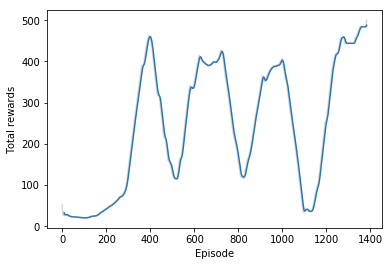

In [20]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

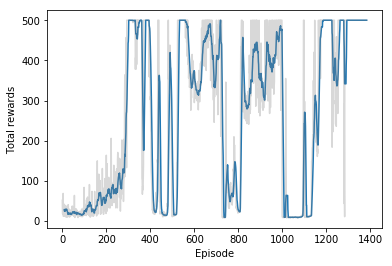

In [21]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

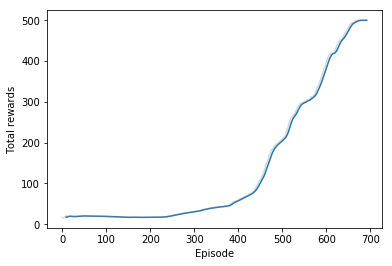

In [20]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

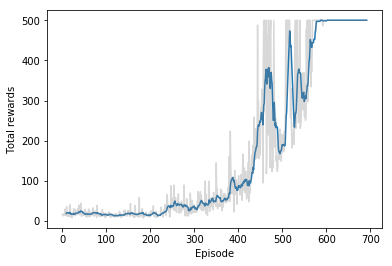

In [21]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Average losses')

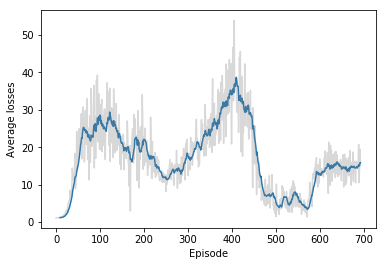

In [22]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

Text(0,0.5,'Total rewards')

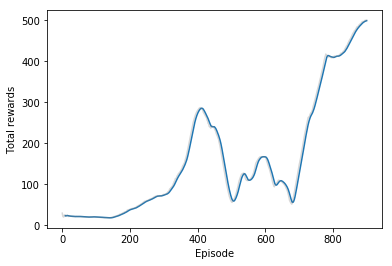

In [42]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

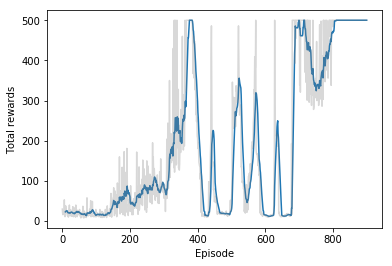

In [43]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

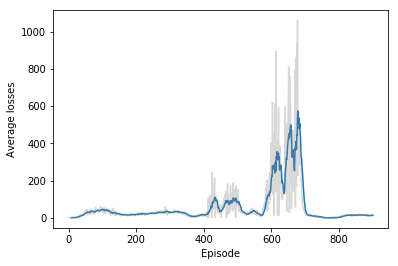

In [44]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [23]:
# Creating a gym env
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

# A training graph session
with tf.Session(graph=graph) as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-qn.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {}'.format(total_reward))
# Close the env at the end
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model-qn.ckpt


/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.